In [1]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [2]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

## An Introduction to Time Series Forecasting with Python
Time series is an important instrument to model, analyze and predict data collected over time. In this talk, we learn the basic theoretical concepts without going deep into mathematical aspects, study different models, and try them in practice using StatsModels, Prophet, scikit-learn, and keras.

# Part 1. Look into the data
******

### OS visits to UK (All visits) 
The dataset represents the monthly total number of visits to the UK by overseas residents (in thousands)<br>from January 1980 to October 2017. 

#### Source: [Office for National Statistics](https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/timeseries/gmaa/ott)

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [27]:
import warnings
warnings.filterwarnings('ignore')

### Load the data into Pandas DataFrame

In [28]:
import pandas as pd
url="https://raw.githubusercontent.com/castudil/Machine-Learning/main/data/GMAA-040218.csv"
df = pd.read_csv(url, header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value.astype(int, copy=False);

In [29]:
df.head(5)

,period,value
0,1980-01-01,739
1,1980-02-01,602
2,1980-03-01,740
3,1980-04-01,1028
4,1980-05-01,1088


In [32]:
df.shape

(454, 2)

In [34]:
df.describe

<bound method NDFrame.describe of         period  value
0   1980-01-01    739
1   1980-02-01    602
2   1980-03-01    740
3   1980-04-01   1028
4   1980-05-01   1088
..         ...    ...
449 2017-06-01   3556
450 2017-07-01   3981
451 2017-08-01   3902
452 2017-09-01   3066
453 2017-10-01   3140

[454 rows x 2 columns]>

In [33]:
max_date = df.period.max()
min_date = df.period.min()

num_of_actual_points = df.index.shape[0]
num_of_expected_points = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month + 1

print("Date range: {} - {}".format(min_date.strftime("%d.%m.%Y"), max_date.strftime("%d.%m.%Y")))
print("Number of data points: {} of expected {}".format(num_of_actual_points, num_of_expected_points))


Date range: 01.01.1980 - 01.10.2017
Number of data points: 454 of expected 454


El número de instancias esperadas coinciden con las que existen realmente en el conjunto de datos. En otras palabras no hay datos faltantes

### Visualize the data

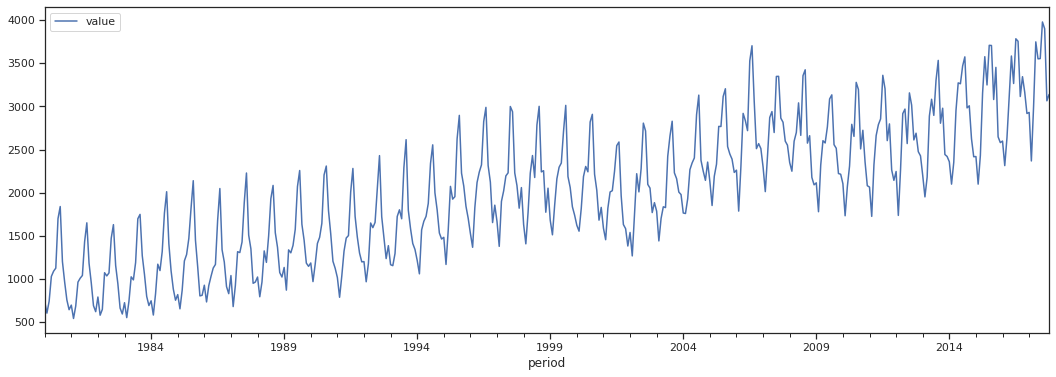

In [35]:
fig, ax = plt.subplots(figsize=(18,6))
df.plot(x="period", y="value", ax=ax)
plt.legend(loc='upper left')

plt.savefig('images/intro-visualization.png'); ## recuerda crear la carpeta 'images'

In **2001** a combination of the outbreak of foot and mouth disease and the September 11 attacks in the US led to a dramatic slump.

In **2009** the global economic crisis, which started to bite in earnest in the autumn, was blamed as a factor for the fall. 

https://www.theguardian.com/business/2009/jul/16/tourism-uk-visitors-fall

In 2006 total visits to the UK by overseas residents were split fairly
equally between three purposes: holiday, visiting friends or relatives,
and business. This pattern is quite different compared with ten years
ago, when ‘holiday’ was the dominant reason

https://www.ons.gov.uk/ons/rel/ott/travel-trends/2006/travel-trends---2006.pdf

The majority of visitors were from North America, followed by tourists from France and Germany.
http://www.bbc.com/news/uk-england-london-27323755

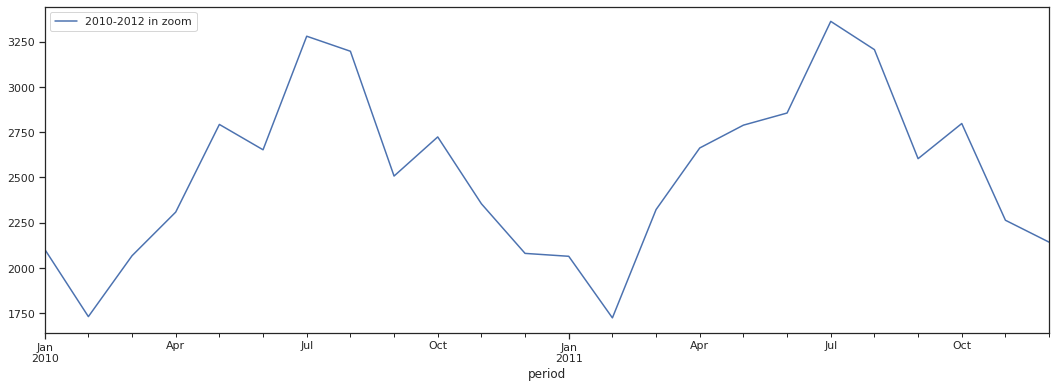

In [40]:
# hacemos una sección de los datos para analizar de cerca lo que pasa en dos años
zoom_range = df[(df.period >= '2010-01-01') & (df.period < '2012-01-01')].index

fig, ax = plt.subplots(figsize=(18,6)) # dimensiones del gráfico
df.loc[zoom_range].plot(x="period", y="value", ax=ax, label="2010-2012 in zoom") ## el gráfico en sí pero considerando el zoom de datos
plt.legend(loc='upper left') # cambiamos la posición por defecto de la leyenda

plt.savefig('images/intro-zoom.png'); ## recuerda crear la carpeta 'images'

#### When is the best time to visit the UK?

The United Kingdom can be visited at any time of year ... Overall, **spring (late March to early June) and autumn (September to November) are the best times to visit**, when it’s usually warm and dry.

https://www.audleytravel.com/us/uk/best-time-to-visit

## Trend and seasonality

From the visualization it's already quite obvious that the OS visits have periodic fluctuations each year and overall tendency to grow up.

Thus, we can conclude that the time series has the **trend** and yearly **seasonality** components, and we can try to decompose them using, for instance, **statsmodels** package.

Note, from the data view we also can suspect that **additive** model better fits for data representation.

In [41]:
#Del paquete statmodel se obtiene un modelo para hacer descomposición de estacionalidad 
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 12  # 12 months seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("period").value.interpolate("linear"),
    freq=decompfreq,
    model=model)

In [21]:
## aquí obtenemos los resultados de la descomposición, en términos de tendencia, estacionalidad y residuos
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

### The Trend

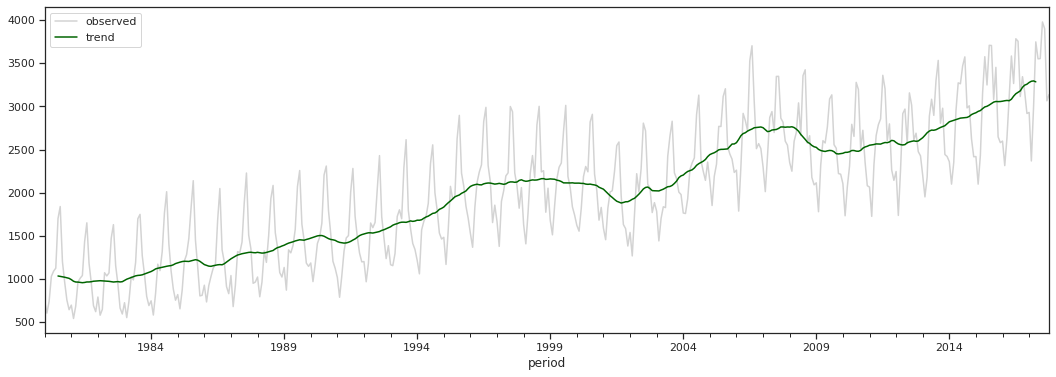

In [52]:
## ahora se realizan los gráficos uno a uno comenzando por la tendencia
fig, ax = plt.subplots(figsize=(18,6))
df.plot(x="period", y="value", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend", color="darkgreen") ## si se fijan aquí se está utilizando el objeto 'trend'
plt.legend(loc='upper left')

plt.savefig('images/intro-trend.png');

### The Seasonality

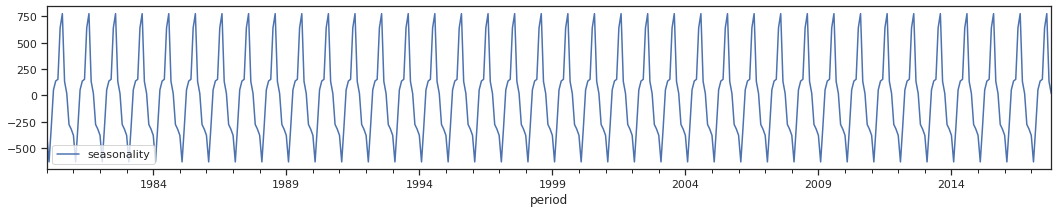

In [53]:
## ahora es el turno de graficar la estacionalidad
fig, ax = plt.subplots(figsize=(18,3)) ## aquí indicamos las proporciones del gráfico, que en este caso se hace un poco más delgados
seasonal.plot(ax=ax, label="seasonality") # aquí se usa el objeto seasonal que se obtuvo los pasos anteriores
plt.legend(loc='bottom left')

plt.savefig('images/intro-seasonality.png');

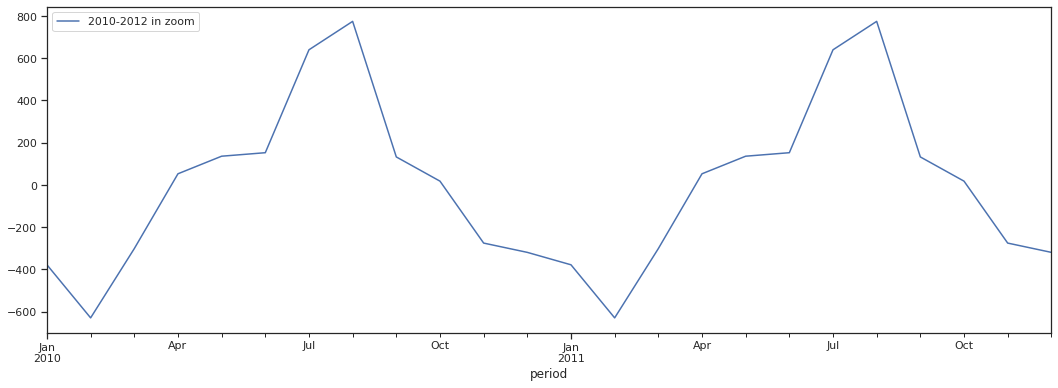

In [24]:
# Otro gráfico de la estacionalidad, pero esta vez haciendo un foco en los dos años antes mencionados, 
# entre 2010 y 2012
fig, ax = plt.subplots(figsize=(18,6))
seasonal[zoom_range].plot(x="period", y="value", ax=ax, label="2010-2012 in zoom")
plt.legend(loc='upper left')

plt.savefig('images/intro-seasonality-zoom.png');

### The Residual

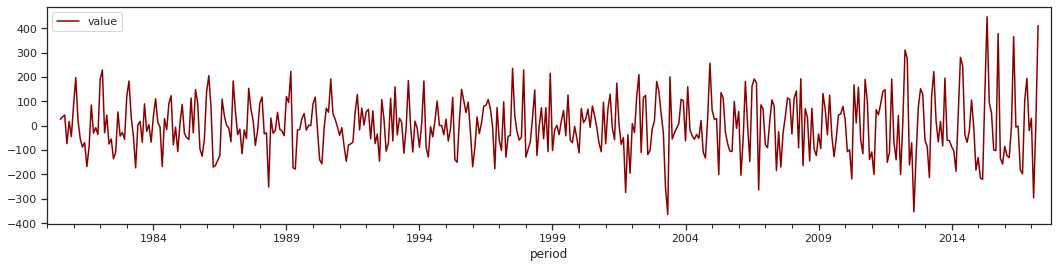

In [49]:
## finalmente gráfica vamos los elementos residuales
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality", color="darkred") ## Y se utiliza el objeto residual que se obtuvo en la descomposición de la serie
plt.legend(loc='upper left')

plt.savefig('images/intro-residual.png');